In [1]:
from os.path import join as j
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import (classification_report, f1_score, precision_score,
                             recall_score)

In [2]:
with open("../data_dirs.txt", "r") as f: # your dataset folder should  be in a text file here
    DATA_DIRS = f.readlines()
    DATA_DIRS = [p.strip() for p in DATA_DIRS]

# KNN

In [3]:
df = pd.DataFrame(
    columns=[
        "EMB_PROPERTY",
        "EMB_METHOD",
        "IS_ALL_JOURNALS",
        "K",
        "AVERAGE",
        "TRIAL",
        "PRECISION",
        "RECALL",
        "F1_SCORE",
    ]
)
df = df.set_index(["EMB_PROPERTY", "EMB_METHOD", "IS_ALL_JOURNALS", "K", "AVERAGE", "TRIAL"])

# Average calculations for multiclass precision/recall/F1
AVGS = ["micro"]

# Classes
CLASSIF = "PACS"

# Files
FIG_PATH_ALL = 'outputs/aps_all_2010_all_{classes}_f1_scores_all.pdf'.format(classes=CLASSIF.casefold())
FIG_PATH_TEXT = 'outputs/aps_all_2010_text_{classes}_f1_scores_all.pdf'.format(classes=CLASSIF.casefold())

In [4]:
# Get file paths
KNN_PATHS = [j(DATA_DIRS[0], "classification", p) for p in os.listdir(j(DATA_DIRS[0], "classification")) if "abstract" in p]
#KNN_PATHS.extend([j(DATA_DIRS[0], "classification", "old_exps", p) for p in os.listdir(j(DATA_DIRS[0], "classification", "old_exps")) if "abstract" in p])

# Fill dataframe with precision, recall, F1 scores of KNN classifications
for filename in [k for k in KNN_PATHS if CLASSIF.casefold() in k]:
    params = filename.split("/")[-1]
    params = params.split("_")
    params[-1] = params[-1].replace(".csv", "")  # remove file extension
    emb_prop = params[3]
    emb_method = params[4]  # get embedding method
    params = params[5:]  # keep only kNN related params
    params = dict(
        [p.split("-") for p in params]
    )  # change params to dictionary with format param: value
    is_all_journals = int(params["alljournals"])
    k = int(params["k"])
    trial = int(params["trial"])
    with open(filename, "r") as f:
        knn = pd.read_csv(f, sep=",")
        for avg in AVGS:
            df.loc[
                (emb_prop, emb_method, is_all_journals, k, avg, trial), "PRECISION"
            ] = precision_score(knn.TRUE_LABEL, knn.PRED_LABEL, average=avg)
            df.loc[
                (emb_prop, emb_method, is_all_journals, k, avg, trial), "RECALL"
            ] = recall_score(knn.TRUE_LABEL, knn.PRED_LABEL, average=avg)
            df.loc[(emb_prop, emb_method, is_all_journals, k, avg), "F1_SCORE"] = f1_score(
                knn.TRUE_LABEL, knn.PRED_LABEL, average=avg
            )

/Users/imconsta-work/opt/miniconda3/envs/embed-sci-disc/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/Users/imconsta-work/opt/miniconda3/envs/embed-sci-disc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [5]:
# Load citation network classification, calculate metrics
CIT_CLASS_PATH = j(DATA_DIRS[0], "classification", "aps_all_2010_cit_net_classes.csv")
cit = pd.read_csv(CIT_CLASS_PATH, index_col=["IS_ALL_JOURNALS", "DOI"])
CLASS_COL = (
    "PACS_1" if CLASSIF.casefold() == "pacs" else "JOURNAL"
)  # column to extract from citation classification
for avg in AVGS:
    cit_focus = cit.loc[0]
    cit_all = cit.loc[1]

    # Precision
    df.loc[("undirected", "citation", 1, 0, avg, 0), "PRECISION"] = precision_score(
        cit_all["TRUE_" + CLASS_COL].dropna().values,
        cit_all["CLASS_" + CLASS_COL].dropna().values,
        average=avg,
    )  # all journals

    # Recall
    df.loc[("undirected", "citation", 1, 0, avg, 0), "RECALL"] = recall_score(
        cit_all["TRUE_" + CLASS_COL].dropna().values,
        cit_all["CLASS_" + CLASS_COL].dropna().values,
        average=avg,
    )  # all journals

    # F1 score
    df.loc[("undirected", "citation", 1, 0, avg, 0), "F1_SCORE"] = f1_score(
        cit_all["TRUE_" + CLASS_COL].dropna().values,
        cit_all["CLASS_" + CLASS_COL].dropna().values,
        average=avg,
    )  # all journals

In [6]:
df["PRECISION"] = pd.to_numeric(df.PRECISION)
df["RECALL"] = pd.to_numeric(df.RECALL)
df["F1_SCORE"] = pd.to_numeric(df.F1_SCORE)
agg_mean = df.groupby(["EMB_PROPERTY", "EMB_METHOD", "IS_ALL_JOURNALS", "K", "AVERAGE"]).mean()
agg_std = df.groupby(["EMB_PROPERTY", "EMB_METHOD", "IS_ALL_JOURNALS", "K", "AVERAGE"]).std()

In [7]:
df = df.sort_index()

In [8]:
EMB_PROPERTY = ["undirected"]*4 + ["title"]*3 + ["abstract"]*3
EMB_METHOD = ["citation", "leigenmap", "node2vec", "residual2vec", "doc2vec", "scibert", "sentencebert", "doc2vec", "scibert", "sentencebert"]
EMB_METHOD_ST = ["Citation", "Laplacian Eigenmap", "node2vec", "residual2vec", "doc2vec (title)", "SciBERT (title)", "Sentence-BERT (title)", "doc2vec (abstract)", "SciBERT (abstract)", "Sentence-BERT (abstract)"]
METRIC = "F1_SCORE"
METRIC_AVG = "micro"
COLORS = ["gray", "teal", "steelblue", "blue", "orchid", "coral", "orange", "darkorchid", "tab:red", "darkorange"]#["gray", "teal", "steelblue", "blue", "tab:red", "hotpink", "magenta", "coral", "orange", "darkorange"]
MARKERS = ["o", "s", "^", "v", "*", "+", "X", "*", "+", "X"]

In [9]:
agg_mean = agg_mean.reset_index()
agg_mean = agg_mean.set_index(["EMB_PROPERTY", "EMB_METHOD", "IS_ALL_JOURNALS", "AVERAGE", "K"])

In [10]:
agg_mean = agg_mean.sort_index()

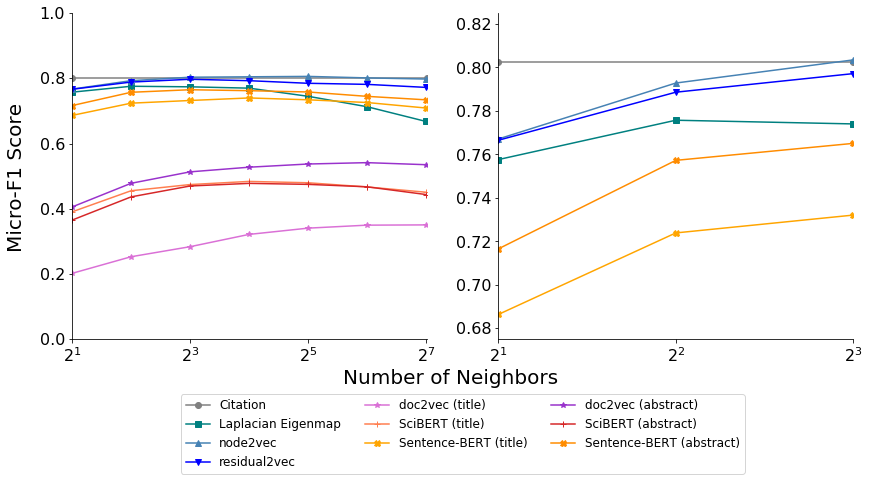

In [12]:
fig = plt.figure(figsize=(14, 6))
fig.text(0.5, 0.035, 'Number of Neighbors', ha='center', va='center', fontsize=20)
fig.text(0.07, 0.5, 'Micro-F1 Score', ha='center', va='center', rotation='vertical', fontsize=20)

# Full range
ax = fig.add_subplot(1, 2, 1)
for i in range(0, len(EMB_METHOD)):
    if i == 0:
        ax.axhline(
            agg_mean.loc[(EMB_PROPERTY[i], EMB_METHOD[i], 1, METRIC_AVG), METRIC][0],
            label=EMB_METHOD_ST[i],
            color=COLORS[i],
            marker=MARKERS[i],
            alpha=1,
        )
    else:
        ax.plot(
            agg_mean.loc[(EMB_PROPERTY[i], EMB_METHOD[i], 1, METRIC_AVG), METRIC],
            label=EMB_METHOD_ST[i],
            color=COLORS[i],
            marker=MARKERS[i],
            alpha=1,
        )
ax.set_ylim(0, 1)
ax.set_xlim(2, 130)
ax.tick_params(axis="both", labelsize=16)
ax.set_xscale("log",basex=2)

# "zoomed-in" version (k => 1 to 8)
ax = fig.add_subplot(1, 2, 2)
for i in range(0, len(EMB_METHOD)):
    if i == 0:
        ax.axhline(
            agg_mean.loc[(EMB_PROPERTY[i], EMB_METHOD[i], 1, METRIC_AVG), METRIC][0],
            label=EMB_METHOD_ST[i],
            color=COLORS[i],
            marker=MARKERS[i],
            alpha=1,
        )
    else:
        ax.plot(
            agg_mean.loc[(EMB_PROPERTY[i], EMB_METHOD[i], 1, METRIC_AVG), METRIC],
            label=EMB_METHOD_ST[i],
            color=COLORS[i],
            marker=MARKERS[i],
            alpha=1,
        )
ax.set_ylim(0.675, 0.825)
ax.set_xlim(2, 8)
ax.tick_params(axis="both", labelsize=16)
ax.set_xscale("log",basex=2)

ax.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), fancybox=True, ncol=3, fontsize=12)
sns.despine()

plt.savefig(
    "aps_all_2010_all_pacs_f1_scores_all_2col.pdf",
    bbox_inches="tight",
)

# Pair emb disc

In [12]:
# Helper for cosine distance
def cos_dist(u, v):
    return 1 - (
        np.einsum("ij,ij->i", u.values, v.values)
        / (np.linalg.norm(u.values, axis=1) * np.linalg.norm(v.values, axis=1))
    )

In [13]:
print(EMB_PROPERTY)
print(EMB_METHOD)
print(EMB_METHOD_ST)
print(COLORS)

['undirected', 'undirected', 'undirected', 'undirected', 'title', 'title', 'title', 'abstract', 'abstract', 'abstract']
['citation', 'leigenmap', 'node2vec', 'residual2vec', 'doc2vec', 'scibert', 'sentencebert', 'doc2vec', 'scibert', 'sentencebert']
['Citation', 'Laplacian Eigenmap', 'node2vec', 'residual2vec', 'doc2vec (title)', 'SciBERT (title)', 'Sentence-BERT (title)', 'doc2vec (abstract)', 'SciBERT (abstract)', 'Sentence-BERT (abstract)']
['gray', 'teal', 'steelblue', 'blue', 'orchid', 'coral', 'orange', 'darkorchid', 'tab:red', 'darkorange']


In [14]:
PAIRS_PATH = os.path.join(DATA_DIRS[0], "derived", "aps_paper_pairs", "aps_all_2010_paper_pairs.gz")#snakemake.input[0]
df = pd.read_csv(PAIRS_PATH, header=0)

/Users/imconsta-work/opt/miniconda3/envs/embed-sci-disc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
same_2 = {}
same_1 = {}
diff = {}
rand = {}

In [16]:
df_all_doi = pd.concat([df.DOI_X, df.DOI_Y]).drop_duplicates().rename("DOI").to_frame()

In [17]:
for i in range(1, len(EMB_METHOD)):
    print(i)
    PROPERTY = EMB_PROPERTY[i]
    EMBEDDING_METHOD = EMB_METHOD[i]
    EMBEDDING_PATH = os.path.join(DATA_DIRS[0], "embedding", "vectors", "aps_all_2010_{}_{}_vector.gz".format(PROPERTY, EMBEDDING_METHOD))
    
    vector = pd.read_csv(EMBEDDING_PATH, header=0).drop_duplicates("DOI").set_index("DOI") # why do SOME (abstract??) vectors have duplicate indices????
    DIM = vector.shape[1]
    vector.columns = list(range(0, DIM))
    
    # why do some sampled pairs have no embedding?
    vector = vector.merge(df_all_doi, left_index=True, right_on="DOI").set_index("DOI")
    pair_df = df[(df.DOI_X.isin(vector.index)) & (df.DOI_Y.isin(vector.index))]
    
    # Split, sample
    same_2[i] = pair_df[pair_df.PACS_CODE_2_X == pair_df.PACS_CODE_2_Y]  # Same PACS level 2
    same_1[i] = pair_df[pair_df.PACS_CODE_1_X == pair_df.PACS_CODE_1_Y].sample(
        n=len(same_2[i])
    )  # Same PACS level 1
    diff[i] = pair_df[pair_df.PACS_CODE_1_X != pair_df.PACS_CODE_1_Y].sample(n=len(same_2[i]))  # Different PACS
    rand[i] = pair_df.sample(n=len(same_2[i]))  # random

    # Calculate cosine distance
    same_2[i]["COS_DIST"] = cos_dist(vector.loc[same_2[i].DOI_X], vector.loc[same_2[i].DOI_Y])
    same_1[i]["COS_DIST"] = cos_dist(vector.loc[same_1[i].DOI_X], vector.loc[same_1[i].DOI_Y])
    diff[i]["COS_DIST"] = cos_dist(vector.loc[diff[i].DOI_X], vector.loc[diff[i].DOI_Y])
    rand[i]["COS_DIST"] = cos_dist(vector.loc[rand[i].DOI_X], vector.loc[rand[i].DOI_Y])

1


/Users/imconsta-work/opt/miniconda3/envs/embed-sci-disc/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2
3
4
5
6
7
8
9


In [18]:
# For prettification of figure
prop_stylized = {
    "undirected": "Undirected Graph",
    "tocited": "Directed (to reference) Graph",
    "tociting": "Directed (to citing paper) Graph",
    "title": "Title",
    "abstract": "Abstract",
    "titleabstract": "Title+Abstract",
    "fulltext": "Full Text",
}
emb_stylized = {
    "leigenmap": "Laplacian Eigenmap",
    "node2vec": "node2vec",
    "residual2vec": "residual2vec",
    "doc2vec": "doc2vec",
    "scibert": "SciBERT",
    "sentencebert": "Sentence-BERT",
}

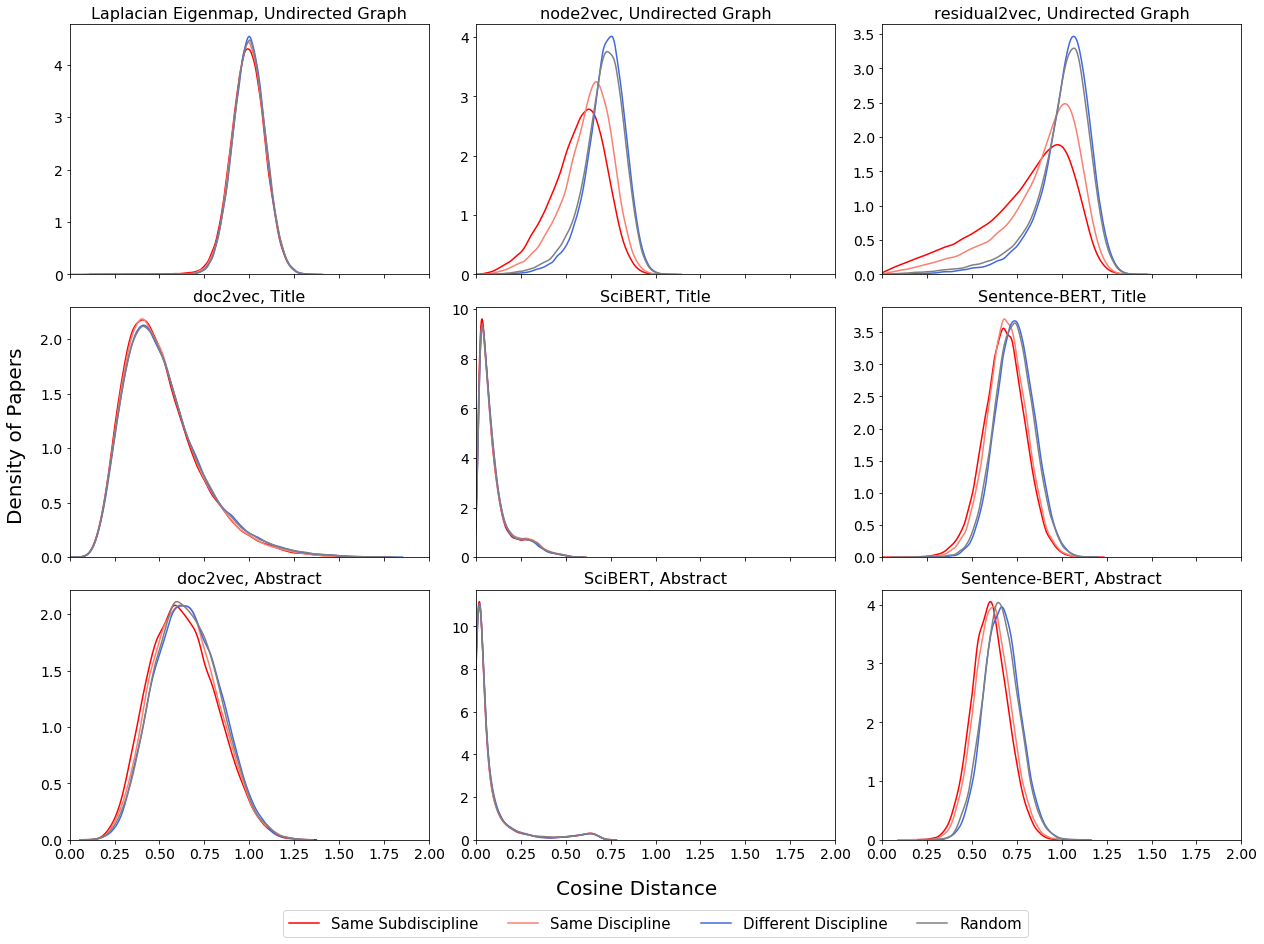

In [36]:
fig = plt.figure(figsize=(21,15))
fig.text(0.5, 0.08, 'Cosine Distance', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Density of Papers', ha='center', va='center', rotation='vertical', fontsize=20)
for i in range(1, len(EMB_METHOD)):
    PROPERTY = EMB_PROPERTY[i]
    EMBEDDING_METHOD = EMB_METHOD[i]
    
    try:
        st_prop = prop_stylized[PROPERTY]
    except KeyError:
        st_prop = PROPERTY
    try:
        st_emb = emb_stylized[EMBEDDING_METHOD]
    except KeyError:
        st_emb = EMBEDDING_METHOD
    
    ax = fig.add_subplot(3,3,i)
    
    sns.kdeplot(same_2[i]["COS_DIST"], label="Same Subdiscipline", color="red", ax=ax)  # level 2 PACS
    sns.kdeplot(same_1[i]["COS_DIST"], label="Same Discipline", color="salmon", ax=ax)  # level 1 PACS
    sns.kdeplot(diff[i]["COS_DIST"], label="Different Discipline", color="royalblue", ax=ax)
    g = sns.kdeplot(rand[i]["COS_DIST"], label="Random", color="gray", ax=ax)
    g.set(xlabel=None, ylabel=None)
    if i < 7:
        g.set(xticklabels=[])
    
    ax.axis(xmin=0,xmax=2, ymin=0)#, ymax=5)
    ax.set_title("{}, {}".format(st_emb, st_prop))  #("{} {} Embedding Cosine Distance".format(st_prop, st_emb))
    ax.title.set_size(16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if i==len(EMB_METHOD)-2:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol=4, fontsize=15)
        
plt.subplots_adjust(wspace=0.13, hspace=0.13)

plt.savefig(
    "aps_all_2010_emb_distance_dist.pdf",
    bbox_inches="tight",
)